## **Utilizing web scraping techniques for gaining valuable company insights**



## Contents

#### 1. Introduction

#### 2. Data Collection

#### 3. Text Mining
    3.1 Data Cleaning
    3.2 Stemming
    
#### 4. Data Analysis
    4.1 Frequency Analysis
    4.2 Word Cloud on Corpus
    4.3 Topic Modelling
    4.4 Sentiment Analysis
    
#### 5. Results & Conclusion

***

### 1. Introduction

In this notebook, I will conduct an analysis of customer reviews to uncover valuable insights about British Airways. The focus will be on scraping reviews from the Skytrax website, cleaning the collected data, and performing various data analyses. Through techniques like topic modeling and sentiment analysis, we will gain a deeper understanding of what aspects are crucial to customers when flying with British Airways.


***

### 2. Data Mining

In [1]:
# package to collect web data 
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import re

import wordcloud
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import gensim
from gensim import corpora

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import textblob
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The code snippet provided below is responsible for collecting data from the following source: https://www.theforage.com/modules/NjynCWzGSaWXQCxSX/X839TXojBwiHpC5va?ref=MpCsFqPdR4z5g7bT8.

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

# how many pages we will scrape:
pages = 20 
# how many reviews per page we will scrape:
page_size = 100

# we will store the scraped reviews in a list named 'reviews'
reviews = []

# for x in range(1, pages + 1):
for x in range(1, pages + 1):

    print(f"Scraping page {x}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{x}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews


* Using scraped reviews to create a dataframe:

In [3]:
import pandas as pd

# Create an empty dataframe
df = pd.DataFrame()

# Assign the scraped reviews to the "reviews" column
df["reviews"] = reviews

# Display the first few rows of the dataframe
df.head(10)

,reviews
0,Not Verified | We will never fly British Airw...
1,✅ Trip Verified | Check in and security cleara...
2,Not Verified | British Airways has confirmed ...
3,✅ Trip Verified | Worst BA experience. I was s...
4,✅ Trip Verified | My daughter and I were deni...
5,✅ Trip Verified | Despite boarding being the u...
6,"Not Verified | Flight cancelled, no crew! 9th..."
7,"Not Verified | The worst service ever, my bag..."
8,✅ Trip Verified | 4/4 flights we booked this ...
9,✅ Trip Verified | British Airways has a total...


* Converting the dataframe to a .csv file *'BA_reviews.csv'*

In [4]:
# Save the dataframe as a CSV file
df.to_csv(r"D:\data.csv", index=False)

***

### 3. Text Mining

In order to prepare our dataset for analysis, we need to address its messy nature and the fact that it consists solely of text. This involves performing data cleaning and stemming to ensure our data is in a suitable format. Once the data cleaning and stemming processes are complete, we can proceed to Section 4, where we will conduct various analyses on the prepared dataset.

#### 3.1 Data Cleaning

In this sub-section, we will be:

* Removing the *'Not Verified |'* and *'✅ Trip Verified |'* strings from the reviews, as they are unneccessary for this task.
* Making all the text in the reviews lowercase.
* Removing non-alphanumeric characters.

In [5]:
# Remove 'Not Verified' from the reviews column
df['reviews'] = df['reviews'].str.replace('Not Verified', '')

# Remove '✅ Trip Verified' from the reviews column
df['reviews'] = df['reviews'].str.replace('✅ Trip Verified', '')

# Remove '|' from the reviews column
df['reviews'] = df['reviews'].str.replace('|', '')

# Convert the reviews to lowercase
df['reviews'] = df['reviews'].str.lower()

# Remove non-alphabetic characters from the reviews column
df['reviews'] = df['reviews'].replace({r'[^a-zA-Z]+': ' '}, regex=True)

# Display the updated dataframe
df.head(10)

,reviews
0,we will never fly british airways again our f...
1,check in and security clearance very quick at...
2,british airways has confirmed itself as the w...
3,worst ba experience i was supposed to fly out...
4,my daughter and i were denied boarding on our...
5,despite boarding being the usual free for all...
6,flight cancelled no crew th september not pea...
7,the worst service ever my baggage did not arr...
8,flights we booked this holiday were delayed a...
9,british airways has a total lack of respect f...


#### 3.2 Stemming

The following code cell will iterate through all 2000 reviews and apply the Porter stemming algorithm to each word within each review. The resulting clean and stemmed reviews will be added to an empty array called Cleaned.

In [6]:
# initializing empty array to append clean text
Cleaned = []
 
# 5000 (reviews) rows to clean
for i in range(0, 2000):
     
    review = df['reviews'][i]
    
    # split to array (default delimiter is " ")
    review = review.split()
     
    # creating PorterStemmer object to take main stem of each word
    ps = PorterStemmer()
     
    # loop for stemming each word in string array at ith row   
    review = [ps.stem(word) for word in review
                if not word in set(stopwords.words('english'))]
                 
    # rejoin all string array elements to create back into a string
    review = ' '.join(review) 
     
    # append each string to create array of clean text
    Cleaned.append(review)

Converting `Cleaned` data (currently in a list) into a dataframe:

In [7]:
Cleaned_df = pd.DataFrame (Cleaned, columns = ['reviews'])
Cleaned_df.head(10)

,reviews
0,never fli british airway flight juli lhr lax c...
1,check secur clearanc quick lhr wife use galler...
2,british airway confirm worst airlin uk last mi...
3,worst ba experi suppos fli itali septemb arriv...
4,daughter deni board busi class flight madrid h...
5,despit board usual free lhr group call board w...
6,flight cancel crew th septemb peak holiday per...
7,worst servic ever baggag arriv time flight del...
8,flight book holiday delay hour wifi avail flig...
9,british airway total lack respect custom book ...


***

### 4. Data Analysis

#### 4.1 Frequency Analysis

In [13]:
# Splitting and counting the top review terms
top_review_terms = df['reviews'].str.split(expand=True).stack().value_counts()

# Creating a dataframe for the review terms
review_terms_df = pd.DataFrame(top_review_terms, columns=['terms'])

# Displaying the resulting dataframe
review_terms_df.head(20)

,terms
the,16545
to,11553
and,9876
a,7725
was,7090
i,7026
in,4757
of,4700
on,4198
flight,3816


* Services provided by the airline that are important to customers as keywords include: 'flight', 'seat', 'service', 'time', 'food', 'crew', and 'class'. 

#### 4.2 Word Cloud

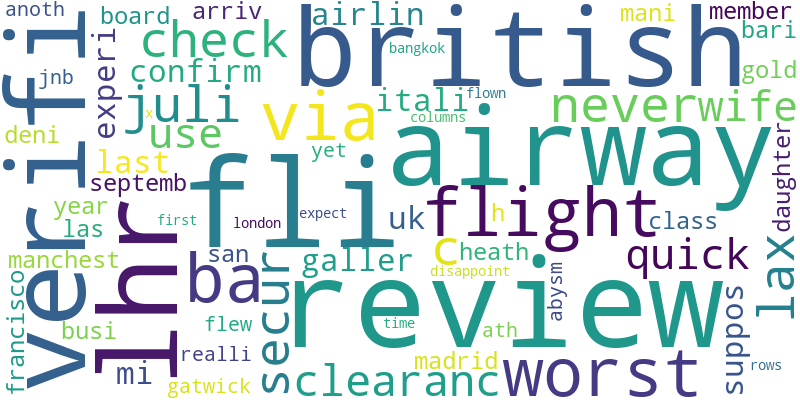

In [16]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=3, contour_color='steelblue', width=800, 
                      height=400)

# Generate a word cloud
wordcloud.generate(str(Cleaned_df))

# Visualize the word cloud
wordcloud.to_image()

From the wordcloud, we can see that some of the most common (and hence most important) words from reviews:

* airway
* worst
* never
* british
* review
* quick
* flight 
* verify 

From this, we can gauge an idea of what customers value.


#### 4.3 Topic Modelling

* For our analysis, we have the option to employ various techniques, including Latent Dirichlet Allocation (LDA), TF-IDF (Term     Frequency-Inverse Document Frequency), or Non-Negative Matrix Factorization (NMF) 
* We convert the corpus to a matrix representation, in this way we can run mathematical models on it.
* We are going to use the gensim library to handle the text data and convert the corpus into a document-term matrix.
* When our document-term matrix has been created, we create an object and train it on the document-term matrix to run the LDA model.


(Code sourced from: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)

In [18]:
# splits each term up in each review
clean_array = [review.split() for review in Cleaned]

# creates term dictionary of our corpus - every unique term is assigned an index. 
dictionary = corpora.Dictionary(clean_array)

# converts list of docs (corpus) into Document Term Matrix using 'dictionary' prepared above.
doc_term_matrix = [dictionary.doc2bow(review) for review in clean_array]

# creating the object for LDA model using gensim library
lda = gensim.models.ldamodel.LdaModel

# running and training LDA model on the document-term matrix.
ldamodel = lda(doc_term_matrix, num_topics=6, id2word = dictionary, passes=50)

print(ldamodel.print_topics(num_topics=6, num_words=6))

[(0, '0.030*"flight" + 0.016*"board" + 0.015*"crew" + 0.012*"time" + 0.011*"check" + 0.011*"servic"'), (1, '0.033*"flight" + 0.020*"ba" + 0.011*"hour" + 0.011*"book" + 0.009*"custom" + 0.008*"told"'), (2, '0.020*"seat" + 0.019*"flight" + 0.015*"ba" + 0.014*"good" + 0.014*"food" + 0.012*"class"'), (3, '0.038*"seat" + 0.020*"economi" + 0.017*"ba" + 0.014*"flight" + 0.013*"class" + 0.011*"premium"'), (4, '0.049*"seat" + 0.019*"flight" + 0.010*"busi" + 0.010*"ba" + 0.008*"class" + 0.007*"passeng"'), (5, '0.022*"flight" + 0.020*"airlin" + 0.018*"ba" + 0.017*"servic" + 0.017*"airway" + 0.016*"british"')]


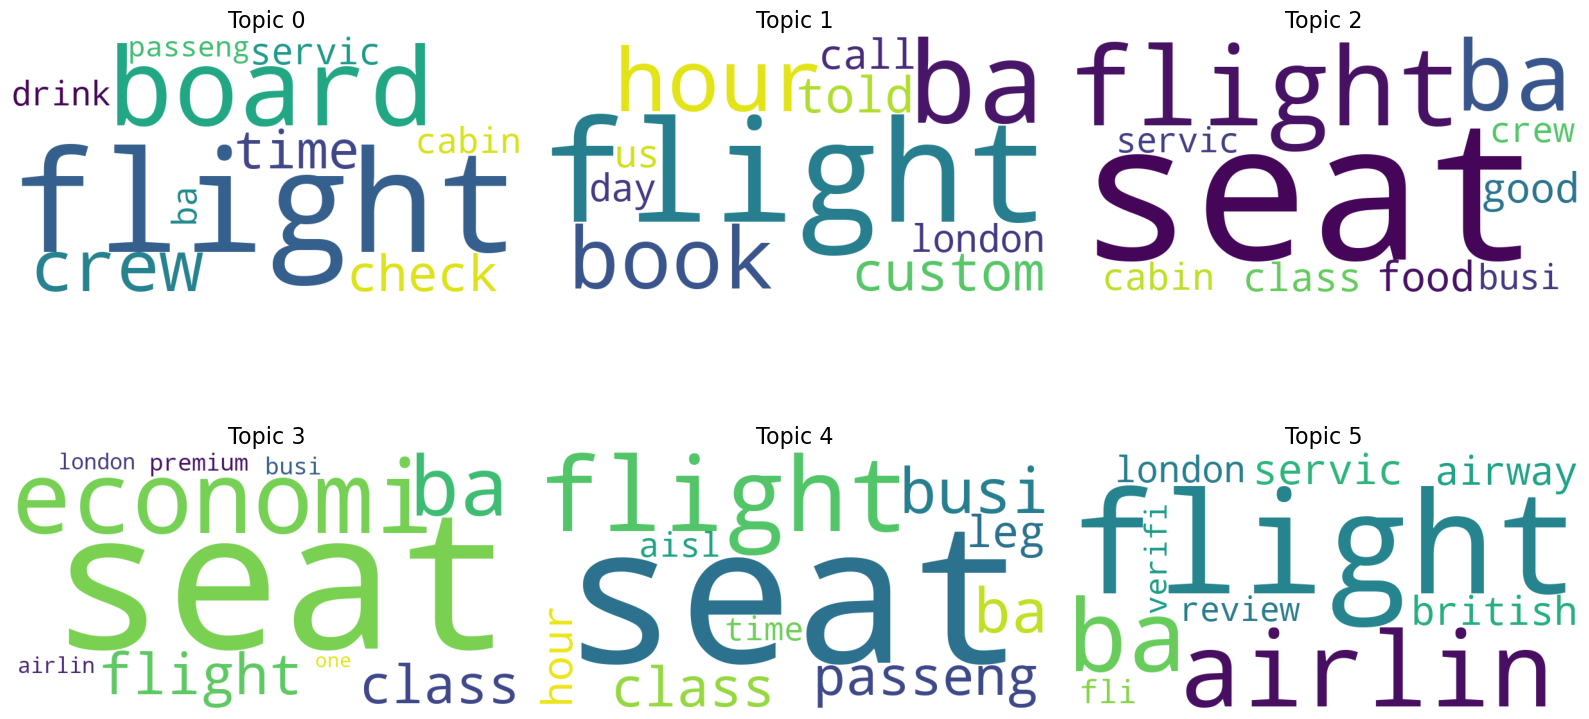

In [20]:
topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    wordcloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
#plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


#### 4.4 Sentiment Analysis

***VADER SENTIMENT***

In [22]:
sent_analyzer = SentimentIntensityAnalyzer()

def vaderAnalysis(vader_dict):
    
    polarity = "Neutral"

    if vader_dict['compound'] <= -0.05:
        return 'Negative'
    elif vader_dict['compound'] >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def vaderPredicts(review):
    
    vader_dict = sent_analyzer.polarity_scores(review)
    return vaderAnalysis(vader_dict)
    

Cleaned_df['vader_analysis'] = Cleaned_df['reviews'].apply(vaderPredicts)

In [23]:
vader_value_counts = Cleaned_df['vader_analysis'].value_counts()
vader_value_counts

Positive    1247
Negative     697
Neutral       56
Name: vader_analysis, dtype: int64

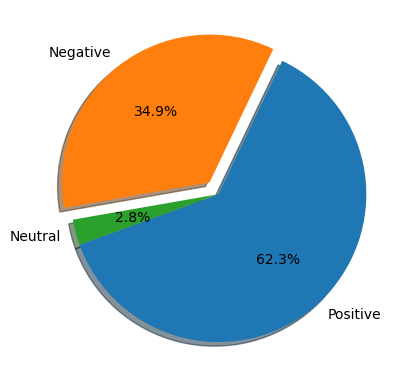

In [33]:
counts = vader_value_counts.to_numpy()
labels =["Positive", "Negative", "Neutral"]
plt.pie(counts, labels = labels, autopct="%1.1f%%", shadow=True, startangle=200, explode=[0,0.1,0])
plt.show()

<Axes: xlabel='vader_analysis', ylabel='count'>

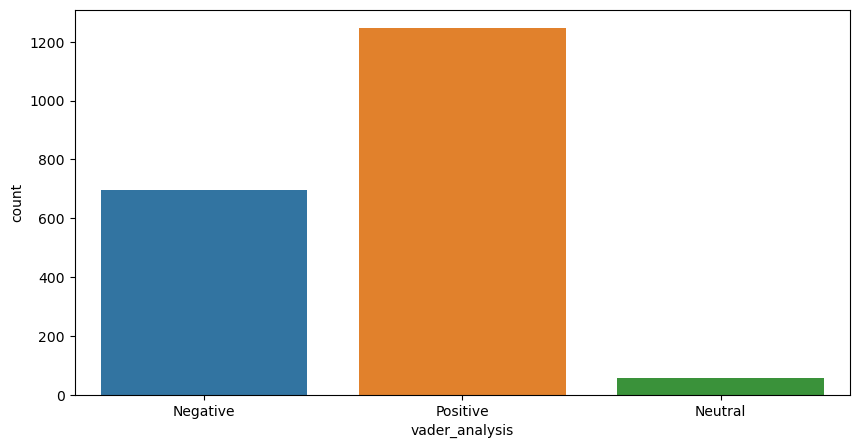

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=Cleaned_df["vader_analysis"])

*Word Cloud on Positive and Negative Sentiments - VADER*

In [36]:
flight_stopwords=stopwords.words('english')
flight_stopwords.extend(["british","ba", "airways", "fly", "flight", "Positive", "Negative", "vader_analysis", 'airway', 'never'])

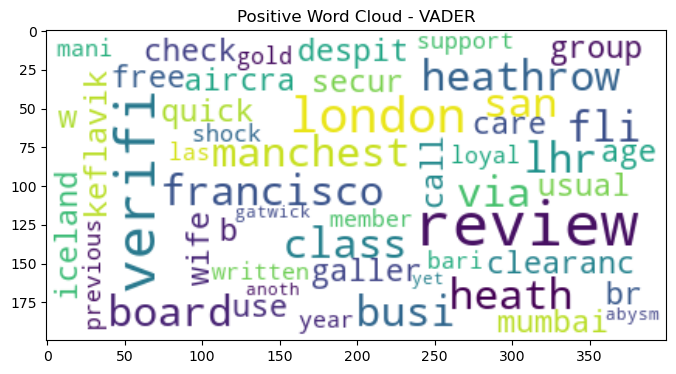

In [39]:
pos=Cleaned_df[Cleaned_df["vader_analysis"]=="Positive"]

wc=WordCloud(background_color='white', max_words=50, max_font_size=40, random_state=0, stopwords=flight_stopwords).generate(str(pos))

fig = plt.figure(1, figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
#plt.axis("off")
plt.title('Positive Word Cloud - VADER')
plt.show()

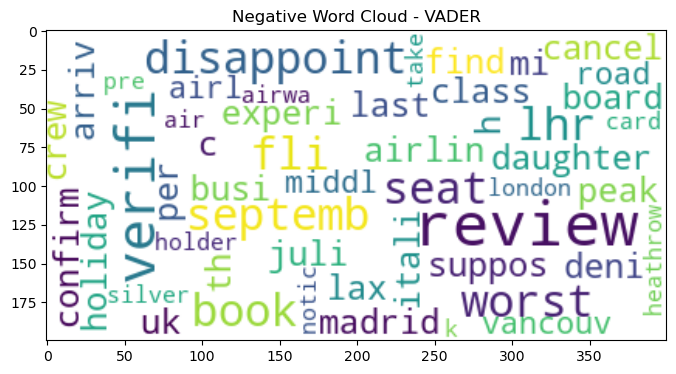

In [40]:
neg=Cleaned_df[Cleaned_df["vader_analysis"]=="Negative"]

wc=WordCloud(background_color='white', max_words=50, max_font_size=40, random_state=0, stopwords=flight_stopwords).generate(str(neg))

fig = plt.figure(1, figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
#plt.axis("off")
plt.title('Negative Word Cloud - VADER')
plt.show()

***TEXT BLOB***

TextBlob returns polarity and subjectivity as outputs.

* *Polarity* - determines the sentiment of the text, measured between -1 and 1. -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.
* *Subjectivity* - whether the text is factual or opinion-based. Measure is between 0 and 1, where a value closer to 0 is more objective and a value closer to 1 is more subjective.

In [42]:
Cleaned_df['textblob_subjectivity'] = Cleaned_df['reviews'].apply(lambda review: TextBlob(review).sentiment.subjectivity)
Cleaned_df['textblob_polarity'] = Cleaned_df['reviews'].apply(lambda review: TextBlob(review).sentiment.polarity)
Cleaned_df.head()

,reviews,vader_analysis,textblob_subjectivity,textblob_polarity
0,never fli british airway flight juli lhr lax c...,Negative,0.000000,0.000000
1,check secur clearanc quick lhr wife use galler...,Positive,0.437302,0.291270
2,british airway confirm worst airlin uk last mi...,Negative,0.355556,-0.333333
3,worst ba experi suppos fli itali septemb arriv...,Negative,0.279167,-0.083333
4,daughter deni board busi class flight madrid h...,Negative,0.210145,-0.008152


In [44]:
Cleaned_df['textblob_sentiment']=''

Cleaned_df.loc[Cleaned_df.textblob_polarity>0,'textblob_sentiment']='Positive'
Cleaned_df.loc[Cleaned_df.textblob_polarity==0,'textblob_sentiment']='Neutral'
Cleaned_df.loc[Cleaned_df.textblob_polarity<0,'textblob_sentiment']='Negative'

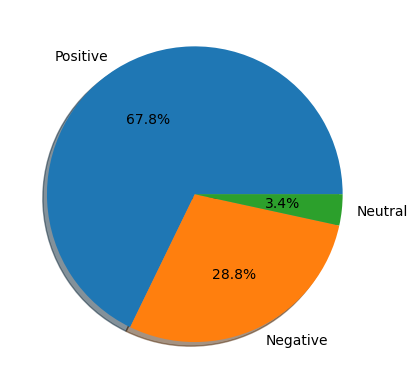

In [46]:
tb_value_counts = Cleaned_df['textblob_sentiment'].value_counts()
counts = tb_value_counts.to_numpy()
labels =["Positive", "Negative", "Neutral"]
plt.pie(counts, labels = labels, autopct="%1.1f%%", shadow=True)
plt.show()

<Axes: xlabel='textblob_sentiment', ylabel='count'>

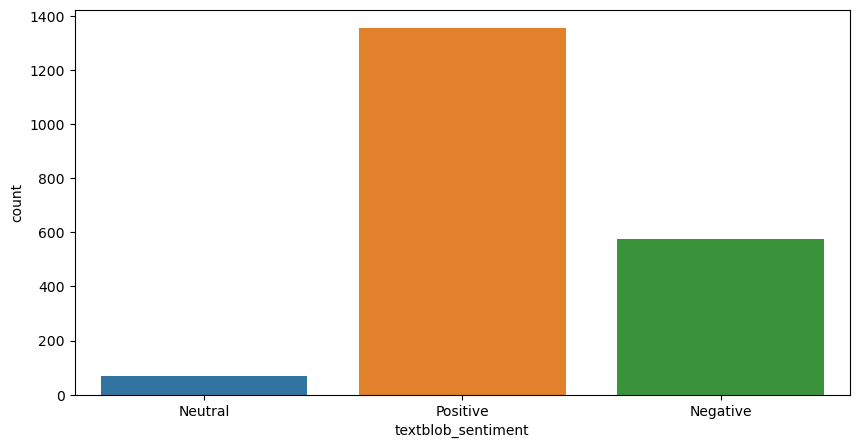

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=Cleaned_df['textblob_sentiment'])

*Word Cloud on Positive and Negative Sentiments - Text Blob*

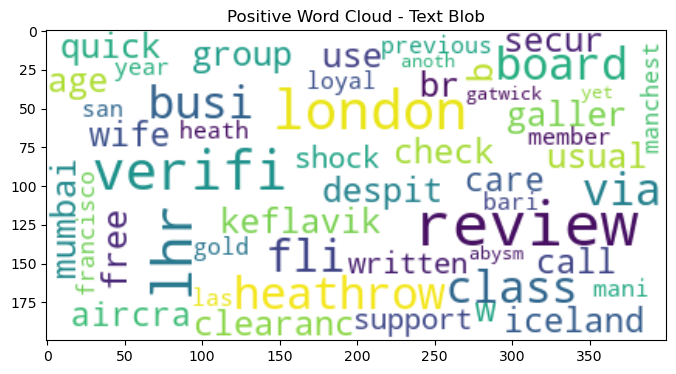

In [49]:
pos=Cleaned_df[Cleaned_df["textblob_sentiment"]=="Positive"]

wc=WordCloud(background_color='white', max_words=50, max_font_size=40, random_state=0, stopwords=flight_stopwords).generate(str(pos))

fig = plt.figure(1, figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
#plt.axis("off")
plt.title('Positive Word Cloud - Text Blob')
plt.show()

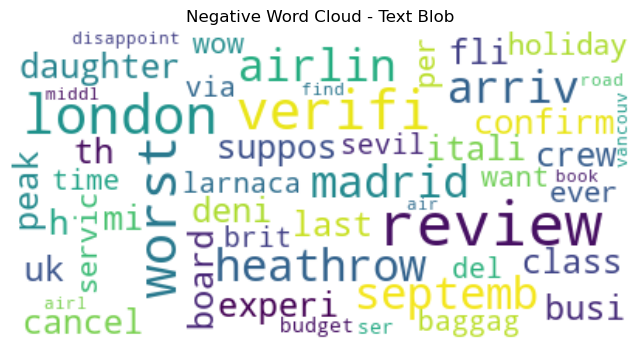

In [50]:
neg=Cleaned_df[Cleaned_df["textblob_sentiment"]=="Negative"]

wc=WordCloud(background_color='white', max_words=50, max_font_size=40, random_state=0, stopwords=flight_stopwords).generate(str(neg))

fig = plt.figure(1, figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Word Cloud - Text Blob')
plt.show()

***

### 5. Results & Conclusion

The frequency analysis and word cloud provide valuable insights into the most prominent words in the corpus, giving an indication of their importance and value to British Airways customers. By applying LDA topic modeling, we categorize the words into six topics, allowing us to infer the themes associated with each.

To further understand the sentiment of the reviews, we utilized VADER and Text Blob. The sentiments were analyzed, and the results were visualized using pie charts, bar graphs, and word clouds. Out of the 1000 reviews analyzed, the majority were positive, accounting for 63.9% based on VADER analysis and 68.1% based on Text Blob. Positive keywords such as 'London,' 'lounge,' 'class,' and 'journey' were frequently mentioned. On the other hand, negative reviews constituted 32.9% according to VADER analysis and 28.3% according to Text Blob. These negative reviews often included keywords like 'Gatwick,' 'seat,' 'race,' and 'crew.'

By examining these analyses, we can identify themes that emerge and utilize them to enhance services in the future. Understanding the positive aspects, such as the mentioned keywords, can guide improvements and reinforce the aspects that are most valued by customers. Similarly, addressing the negative aspects can lead to enhancements in areas such as seat comfort, crew service, and Gatwick-related experiences.